In [1]:
!wget -b https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz


Continuing in background, pid 51.
Output will be written to ‘wget-log.1’.


In [2]:
!tar -xf /notebooks/102flowers.tgz

^C


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt


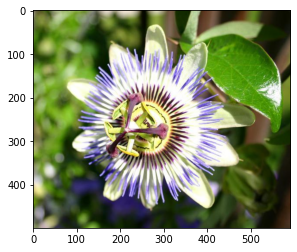

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/notebooks/jpg/image_00001.jpg')
imgplot = plt.imshow(img)
plt.show()

In [30]:
data_dir=r"/notebooks/jpg"
TRAIN_BUF=500
BATCH_SIZE=32
IMG_SHAPE=(64,64,3)
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)

train_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                         image_size=(64, 64),
                                                         seed=42,
                                                         batch_size=BATCH_SIZE,
                                                        shuffle=True,
                                                         labels=None)


Found 8188 files belonging to 1 classes.


In [31]:
for x in train_dataset.take(0):
    for i in (x):
        print(i)

In [32]:
import os 
len(os.listdir(data_dir))

8188

In [33]:

def conv_block(
    x,
    filters,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    use_bias=False,
    activation_layer=layers.LeakyReLU(0.2),
    use_bn=True,
    use_dropout=False,
    drop_value=0.1,
):
    y= layers.Conv2D(
        filters, 1,strides=(2,2), padding=padding, use_bias=use_bias)(x)
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation_layer(x+y)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x

# get function API model
def get_discriminator_model():
    img_input = layers.Input(shape=IMG_SHAPE)
    # Zero pad the input to make the input images size to (32, 32, 1).
    x = conv_block(
        img_input,
        64,
        strides=(2, 2),
        use_dropout=False,
    )
    x = conv_block(
        x,
        64,
        strides=(2, 2),
        use_dropout=False,
    )
    x = conv_block(
        x,
        128,
        kernel_size=(3, 3),
        strides=(2, 2),
        use_dropout=True,
    )
    x = conv_block(
        x,
        256,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_dropout=True,
    )
    x = conv_block(
        x,
        512,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_dropout=False,
    )

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model


d_model = get_discriminator_model()
d_model.summary()


Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 32, 32, 64)   1728        ['input_3[0][0]']                
                                                                                                  
 batch_normalization_10 (BatchN  (None, 32, 32, 64)  256         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_19 (Conv2D)             (None, 32, 32, 64)   192         ['input_3[0][0]']    

In [34]:
noise_dim = 512

def upsample_block(
    x,
    filters,
    activation=layers.LeakyReLU(0.2),
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
):
    y = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2DTranspose(filters, (4, 4), strides=up_size, padding='same', use_bias=False, 
                               kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
    y = layers.Conv2D(
        filters, 1, strides=strides, padding=padding, use_bias=use_bias
    )(y)

    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    
    if use_bn:
        x = layers.BatchNormalization()(x)

    x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x

# get function API model
def get_generator_model():
    noise = layers.Input(shape=(noise_dim,))
    x = layers.Dense(4 * 4 * 256, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Reshape((4, 4, 256))(x)
    x = upsample_block(
        x,
        128,
        strides=(1, 1),
        use_bn=True,
    )
    
    x = upsample_block(
        x,
        256,
        strides=(1, 1),
        use_bn=True,
    )
    x = upsample_block(
        x,
        512,
        strides=(1, 1),
        use_bn=True,
    )
    
    x = upsample_block(
        x,
        256,
        strides=(1, 1),
        use_bn=True,
    )
    x = layers.Conv2D(
        3,(3,3), padding="same",)(x)
    # At this point, we have an output which has the same shape as the input, (32, 32, 1).

    g_model = keras.models.Model(noise, x, name="generator")
    return g_model


g_model = get_generator_model()
g_model.summary()


Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 4096)         2097152     ['input_4[0][0]']                
                                                                                                  
 batch_normalization_15 (BatchN  (None, 4096)        16384       ['dense_3[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 leaky_re_lu_5 (LeakyReLU)      (None, 4096)         0           ['batch_normalization_15[

In [35]:
class WGAN(tf.keras.Model):
    """[summary]
    I used github/LynnHo/DCGAN-LSGAN-WGAN-GP-DRAGAN-Tensorflow-2/ as a reference on this.
    
    Extends:
        tf.keras.Model
    """

    def __init__(self,gen,disc, **kwargs):
        super(WGAN, self).__init__()
        self.__dict__.update(kwargs)

        self.gen = gen
        self.disc = disc
        self.latent_dim=noise_dim

    def generate(self, z):
        return self.gen(z)

    def discriminate(self, x):
        return self.disc(x)

    def compute_loss(self, x):
        """ passes through the network and computes loss
        """
        ### pass through network
        # generating noise from a uniform distribution

        z_samp = tf.random.normal(shape=(x.shape[0], self.latent_dim))

        # run noise through generator
        x_gen = self.generate(z_samp)
        # discriminate x and x_gen
        logits_x = self.discriminate(x)
        logits_x_gen = self.discriminate(x_gen)

        # gradient penalty
        d_regularizer = self.gradient_penalty(x, x_gen)
        ### losses
        disc_loss = (
            tf.reduce_mean(logits_x)
            - tf.reduce_mean(logits_x_gen)
            + d_regularizer * self.gradient_penalty_weight
        )

        # losses of fake with label "1"
        gen_loss = tf.reduce_mean(logits_x_gen)

        return disc_loss, gen_loss

    def compute_gradients(self, x):
        """ passes through the network and computes loss
        """
        ### pass through network
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = self.compute_loss(x)

        # compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)

        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return gen_gradients, disc_gradients

    def apply_gradients(self, gen_gradients, disc_gradients):

        self.gen_optimizer.apply_gradients(
            zip(gen_gradients, self.gen.trainable_variables)
        )
        self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.disc.trainable_variables)
        )

    def gradient_penalty(self, x, x_gen):
        epsilon = tf.random.uniform([x.shape[0], 1, 1, 1], 0.0, 1.0)
        x_hat = epsilon * x + (1 - epsilon) * x_gen
        with tf.GradientTape() as t:
            t.watch(x_hat)
            d_hat = self.discriminate(x_hat)
        gradients = t.gradient(d_hat, x_hat)
        ddx = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=[1, 2]))
        d_regularizer = tf.reduce_mean((ddx - 1.0) ** 2)
        return d_regularizer

    @tf.function
    def train(self, train_x):
        gen_gradients, disc_gradients = self.compute_gradients(train_x)
        self.apply_gradients(gen_gradients, disc_gradients)

In [36]:

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5) + 127.5

        for i in range(self.num_img):
            img = generated_images[i].numpy()
            img = keras.preprocessing.image.array_to_img(img)
            img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))



In [37]:

# optimizers
gen_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(0.0005)# train the model
# model
model = WGAN(
    gen = g_model,
    disc = d_model,
    gen_optimizer = gen_optimizer,
    disc_optimizer = disc_optimizer,
    gradient_penalty_weight = 10.0
)

In [38]:
import pandas as pd
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

In [39]:
from tqdm import tqdm

In [42]:
n_epochs = 1500
for epoch in range(200,n_epochs):
    # train
    for batch, train_x in (zip(range(N_TRAIN_BATCHES), train_dataset)):
        model.train(train_x)
        loss = []
        loss.append(model.compute_loss(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    model.disc.save_weights(fr"/notebooks/model_weights/disc/ckpt{epoch}")
    model.gen.save_weights(fr"/notebooks/model_weights/gen/ckpt{epoch}")
    print(f"Epoch - {epoch};loss- {np.mean(loss)}")


Epoch - 200;loss- 1171256.125
Epoch - 201;loss- -1651999.875
Epoch - 202;loss- 1382593.25
Epoch - 203;loss- 1818707.5
Epoch - 204;loss- -326628.53125
Epoch - 205;loss- 1185154.0
Epoch - 206;loss- -720987.9375
Epoch - 207;loss- 931747.1875
Epoch - 208;loss- -4158030.75
Epoch - 209;loss- 2480298.0
Epoch - 210;loss- -1874992.75
Epoch - 211;loss- 190896.0
Epoch - 212;loss- 2853281.25
Epoch - 213;loss- -122396.78125
Epoch - 214;loss- -3861952.5
Epoch - 215;loss- 2461820.0
Epoch - 216;loss- 1801093.0
Epoch - 217;loss- 797707.875
Epoch - 218;loss- -1158884.75
Epoch - 219;loss- 591897.125
Epoch - 220;loss- -1188787.5
Epoch - 221;loss- -92887.8984375
Epoch - 222;loss- -1230198.5
Epoch - 223;loss- -1253004.875
Epoch - 224;loss- 85441.96875
Epoch - 225;loss- 105763.78125
Epoch - 226;loss- -660851.0
Epoch - 227;loss- -327835.90625
Epoch - 228;loss- -238122.765625
Epoch - 229;loss- -560751.125
Epoch - 230;loss- 16410.4375
Epoch - 231;loss- -702011.0
Epoch - 232;loss- -284618.59375
Epoch - 233;loss-

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


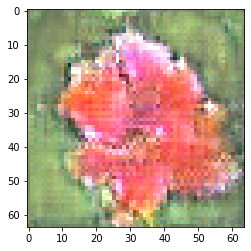

In [73]:
answer=model.gen( tf.random.normal(shape=(32, 512)))[5]
answer=(answer-tf.math.reduce_min(answer))/(tf.math.reduce_max(answer)+tf.math.reduce_min(answer))
plt.imshow(answer)

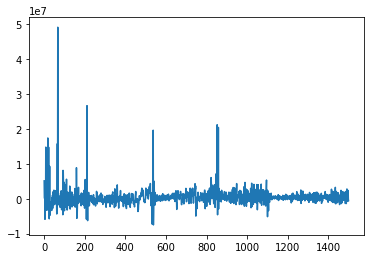

In [45]:
plt.plot(losses["gen_loss"])

In [47]:
abs(losses["gen_loss"]).min()

583.38184

In [54]:
!pip install tensorflow_transform

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.8/439.8 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 17.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.6/25.6 MB 11.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 3.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.6/21.6 MB 10.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 56.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 38.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 60.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 32.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━